<a href="https://colab.research.google.com/github/samsee/hgmldl2023/blob/main/hgmldl2023_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6장. 비지도 학습

## 군집 알고리즘

In [2]:
!wget https://bit.ly/fruits_300_data -O fruits_300.npy

--2023-02-12 00:37:48--  https://bit.ly/fruits_300_data
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy [following]
--2023-02-12 00:37:48--  https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy [following]
--2023-02-12 00:37:49--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... conne

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
fruits = np.load('fruits_300.npy')

In [5]:
# 300장 * 100 px * 100 px
fruits.shape

(300, 100, 100)

In [6]:
fruits[0, 0, :]

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   2,   1,   2,   2,   2,   2,   2,   2,   1,   1,
         1,   1,   1,   1,   1,   1,   2,   3,   2,   1,   2,   1,   1,
         1,   1,   2,   1,   3,   2,   1,   3,   1,   4,   1,   2,   5,
         5,   5,  19, 148, 192, 117,  28,   1,   1,   2,   1,   4,   1,
         1,   3,   1,   1,   1,   1,   1,   2,   2,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1], dtype=uint8)

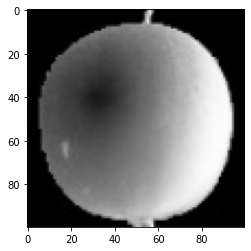

In [7]:
# 그림으로 보기
plt.imshow(fruits[0], cmap='gray')
plt.show()

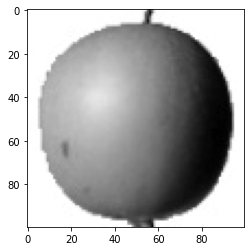

In [8]:
# 데이터는 반전되어 있다(255 -> 0, 0 -> 255)
# 배경(0)이 학습에 영향을 미치지 않도록 하고, 오브젝트의 특징을 잘 잡아낼 수 있도록 큰 숫자로 남게 만듦.
plt.imshow(fruits[0], cmap='gray_r')
plt.show()

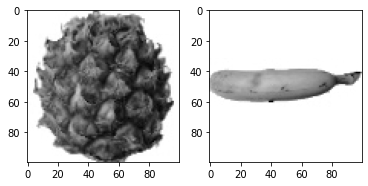

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fruits[100], cmap='gray_r')
axs[1].imshow(fruits[200], cmap='gray_r')
plt.show()

* 2차원 배열을 1차원으로 바꿈
* 타겟별로 나눔 : 비지도 학습에서 실제로는 할 수 없지만..

In [10]:
apple = fruits[0:100].reshape(-1, 100*100)
pineapple = fruits[100:200].reshape(-1, 100*100)
banana = fruits[200:300].reshape(-1, 100*100)

* 각 이미지의 평균값을 가지고 특징을 잡아낼 수 있을까?

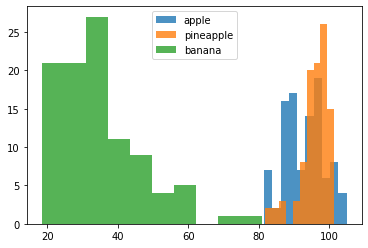

In [11]:
plt.hist(np.mean(apple, axis=1), alpha=0.8)
plt.hist(np.mean(pineapple, axis=1), alpha=0.8)
plt.hist(np.mean(banana, axis=1), alpha=0.8)
plt.legend(['apple', 'pineapple', 'banana'])
plt.show()

* 각 픽셀의 평균값으로 특징을 잡아낼 수 있을까?

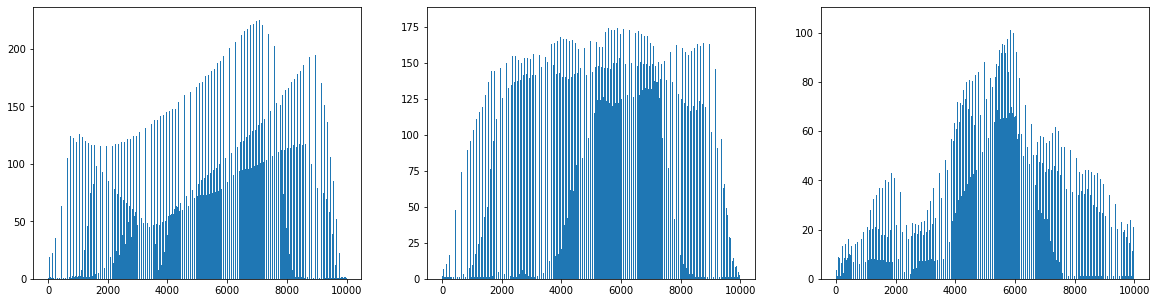

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].bar(range(10000), np.mean(apple, axis=0))
axs[1].bar(range(10000), np.mean(pineapple, axis=0))
axs[2].bar(range(10000), np.mean(banana, axis=0))
plt.show()

* 픽셀 평균값을 이미지로 보기

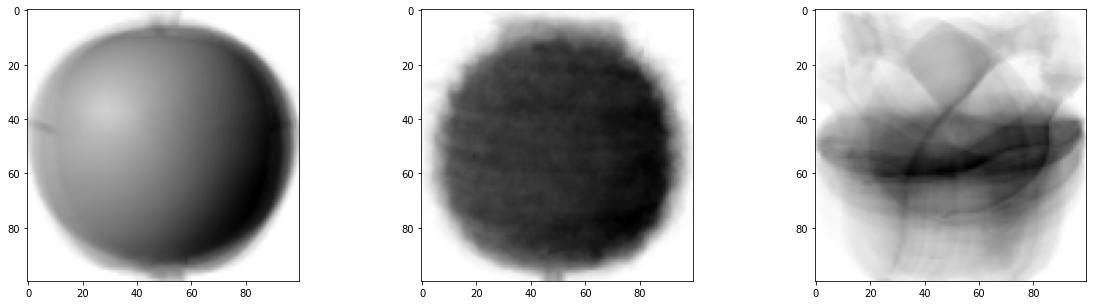

In [13]:
apple_mean = np.mean(apple, axis=0).reshape(100, 100)
pineapple_mean = np.mean(pineapple, axis=0).reshape(100, 100)
banana_mean = np.mean(banana, axis=0).reshape(100, 100)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(apple_mean, cmap='gray_r')
axs[1].imshow(pineapple_mean, cmap='gray_r')
axs[2].imshow(banana_mean, cmap='gray_r')
plt.show()

### 평균값과 가까운 사진 고르기

* 절대값 오차로 가장 가까운 타겟을 골라본다.

In [14]:
# 평균(abs(전체 이미지 - 사과 평균값))
abs_diff = np.abs(fruits - apple_mean)
abs_mean = np.mean(abs_diff, axis=(1,2))

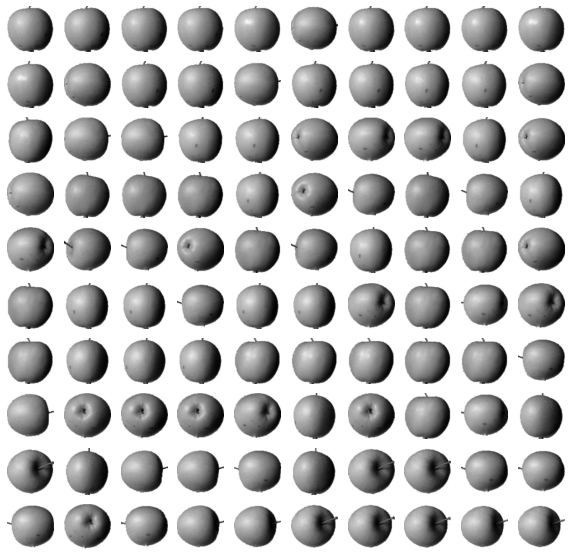

In [15]:
apple_index = np.argsort(abs_mean)[:100]
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(fruits[apple_index[i*10 + j]], cmap='gray_r')
        axs[i, j].axis('off')
plt.show()

* 평균값으로 군집을 찾을 수 있었다.
* 하지만 실제로는 타겟값을 모르기 때문에 평균을 구할 수 없다.

In [16]:
# 확인문제 2 : 바나나
# 평균(abs(전체 이미지 - 바나나 평균값))
abs_diff = np.abs(fruits - banana_mean)
abs_mean = np.mean(abs_diff, axis=(1,2))

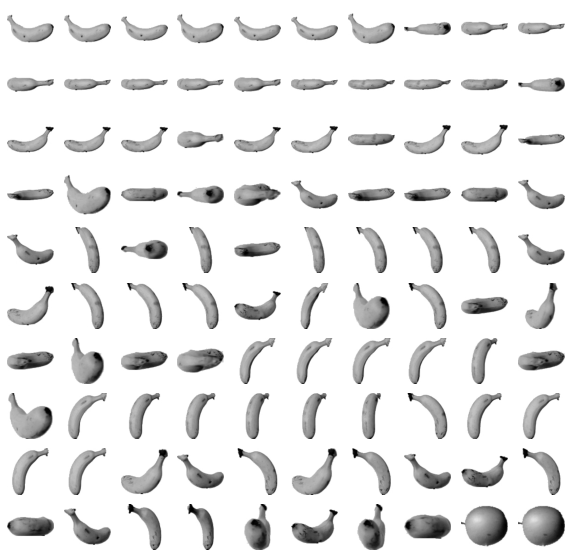

In [17]:
banana_index = np.argsort(abs_mean)[:100]
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(fruits[banana_index[i*10 + j]], cmap='gray_r')
        axs[i, j].axis('off')
plt.show()

## k-평균

* 군집 알고리즘 중 기초적
* 작동 방식
  1. 무작위로 k개를 샘플링해서 클러스터 중심을 찾는다.
  2. 모든 샘플에 대해 가장 가까운 클러스터 중심으로 샘플을 지정
  3. 평균값으로 클러스터 중심 재계산
  4. 중심에 변화가 없을 때 까지 2번 부터 계속..
* sklearn.cluster.KMeans
* 클러스터가 몇 개 있는지는(n_clusters) 어떻게 알지?

In [18]:
import numpy as np

fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

In [19]:
# 학습
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_2d)

KMeans(n_clusters=3, random_state=42)

In [20]:
# 분류 결과 출력
print(km.labels_)
# 라벨 순서가 뭘 의미하는지 알려면 출력해봐야..

[2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [21]:
km.score(fruits_2d)
# 무슨 뜻일까.. 절대값 오차의 합계인가?

-5074977316.088373

In [22]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
    n = len(arr)
    
    rows = int(np.ceil(n/10))
    
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

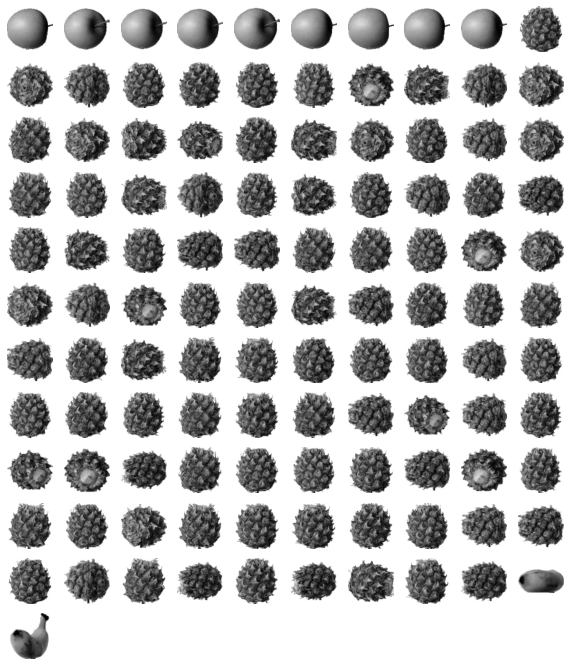

In [23]:
# 0번으로 분류된 데이터 보기
draw_fruits(fruits[km.labels_==0])

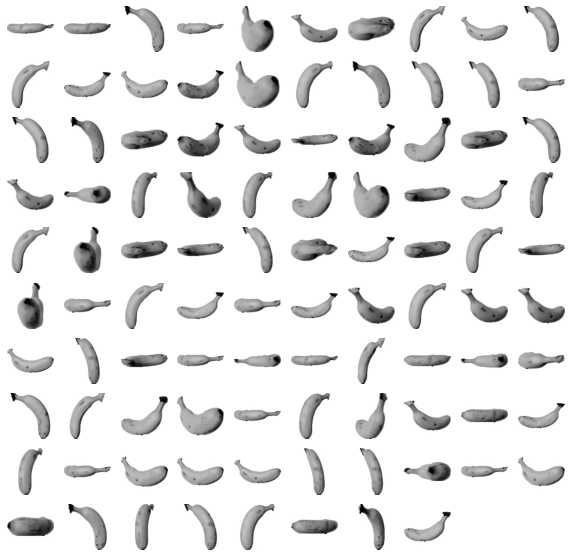

In [24]:
draw_fruits(fruits[km.labels_==1])

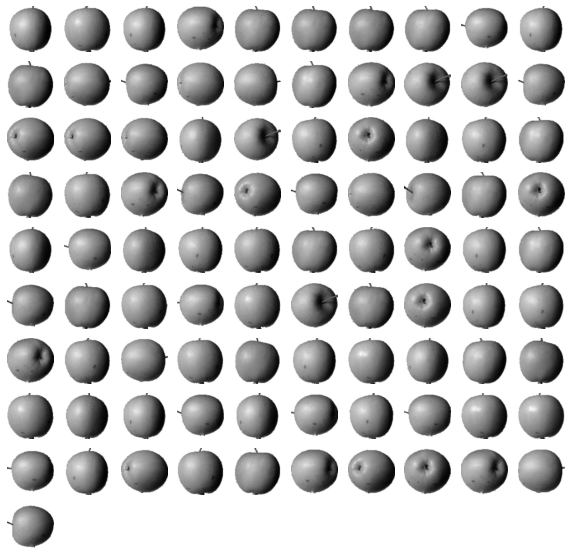

In [25]:
draw_fruits(fruits[km.labels_==2])

In [26]:
km.cluster_centers_.shape

(3, 10000)

In [27]:
km.transform(fruits_2d[100:101])

array([[3393.8136117 , 8837.37750892, 5267.70439881]])

* 실제로는 몇 개의 클러스터가 존재하는지도 알 수 없다.

### 최적의 k 찾기

* 완벽한 방법은 없다.
* 이너셔(inertia) 방법

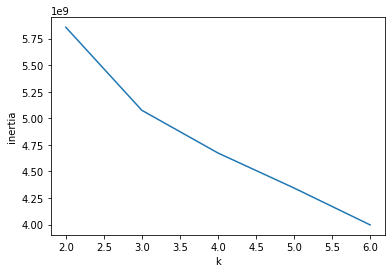

In [28]:
inertia = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(fruits_2d)
    inertia.append(km.inertia_)

plt.plot(range(2, 7), inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

## 주성분 분석

* 차원 축소: 데이터를 가장 잘 나타내는 일부 특성을 선택하여 데이터의 크기를 줄이고 지고 학습 모델의 성능을 향상시키는 방법
* PCA 모델: 데이터에 있는 분산이 큰 방향을 찾는 것(주성분)
  * 주성분을 특성 만큼 찾으면 그걸로 벡터를 요약할 수 있다.

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50) # 찾으려는 주성분의 수 -> compoments_.shape[0] 적당히 50개로 정한거?
pca.fit(fruits_2d)

PCA(n_components=50)

In [32]:
print(fruits_2d.shape)
print(pca.components_.shape)

(300, 10000)
(50, 10000)


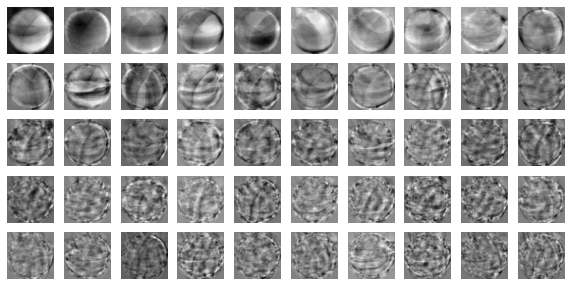

In [34]:
draw_fruits(pca.components_.reshape(-1, 100, 100))
# 이기 뭐꼬..

* 원본 데이터에서 가장 분산이 큰 방향을 순서대로 나타낸 것
  * 데이터셋에 있는 어떤 특징을 잡아낸 것처럼 생각할 수도..

* 원본 데이터를 주성분에 투영(10000 -> 50개로 줄이기)

In [36]:
fruits_pca = pca.transform(fruits_2d)
fruits_pca.shape

(300, 50)

### 원본 데이터 재구성

* 복원

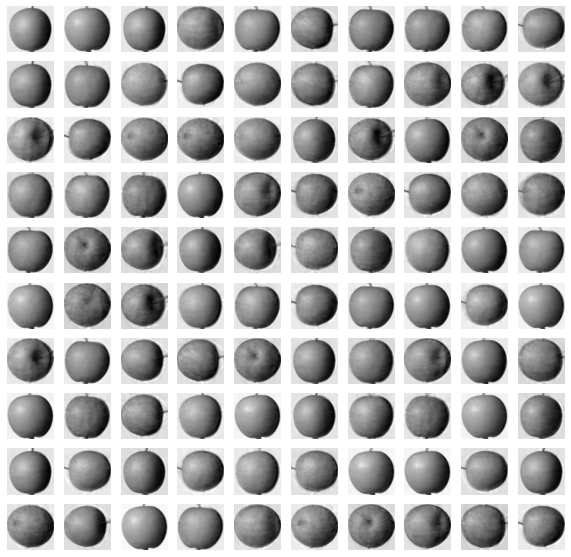

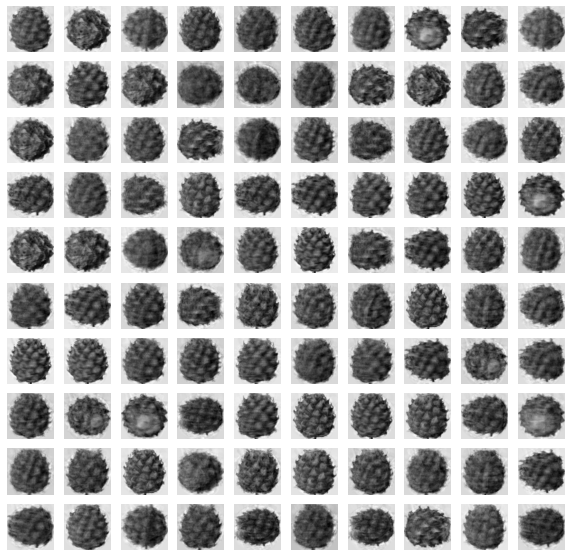

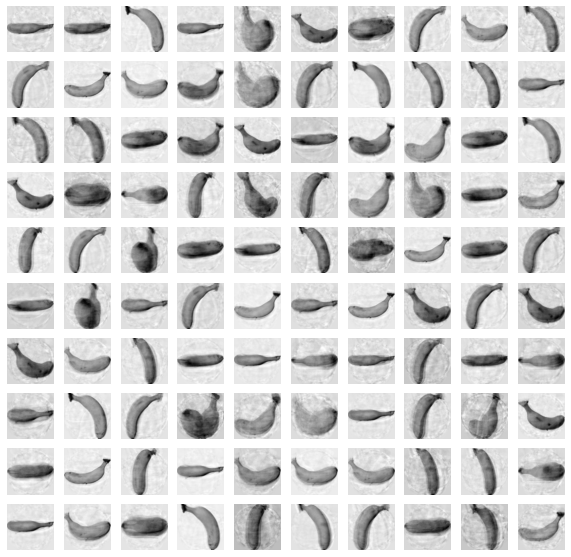

In [37]:
fruits_inverse = pca.inverse_transform(fruits_pca)

fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)

for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

### 설명된 분산

0.9215675934367592


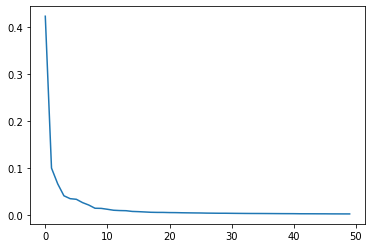

In [41]:
print(np.sum(pca.explained_variance_ratio_))
# 이게 높으면 원본 데이터의 특성을 잘 나타내는 것으로 볼 수 있다.
plt.plot(pca.explained_variance_ratio_)
# 설명된 분산 비율이 들어 있다. 각 원소가 원본 데이터의 분산을 얼마나 잘 나타내는지로 해석할 수 있음.

In [40]:
pca.explained_variance_ratio_[0:10]

array([0.42357017, 0.09941755, 0.06577863, 0.04031172, 0.03416875,
       0.03281329, 0.02573267, 0.02054963, 0.01372276, 0.01342773])

### 차원 축소 활용

* 축소된 데이터로 기반으로 학습한 모델을 사용할 수 있다

### 차원축소 + 로지스틱 회귀

In [43]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
target = np.array([0] * 100 + [1] * 100 + [2] * 100)

In [44]:
from sklearn.model_selection import cross_validate

# 원본 데이터로 하면..
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time'])) # 학습에 걸린 시간

0.9966666666666667
1.944232416152954


In [45]:
# PCA 데이터로 하면..
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time'])) # 학습에 걸린 시간(매우 빨라짐)

1.0
0.030928611755371094


* PCA는 주성분의 개수 대신 설명된 분산 비율(목표값)을 찾을 때 까지 학습시킬 수 있다.
  * n_components에 0~1 사이의 실수

In [46]:
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)
print(pca.n_components_) # 2개 성분으로 50% 정도의 분산을 설명할 수 있음.

2


In [51]:
fruits_pca = pca.transform(fruits_2d)
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
0.07522711753845215


### 차원축소 + k-평균

In [52]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)

KMeans(n_clusters=3, random_state=42)

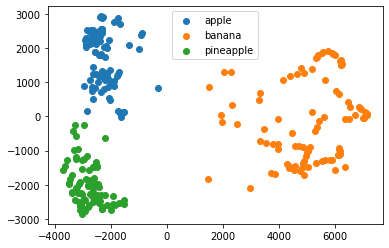

In [53]:
# 차원이 2차원으로 축소 되어서 시각화 하기도 좋다.

for label in range(0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()

### 미션

1. 특성이 20개인 대량의 데이터셋에서 찾을 수 있는 주성분의 갯수는?
  * 20개
  * 설명: 주성분의 특성의 수와 샘플 개수 중 작은 값만큼 찾을 수 있다(p.322).
2. (1000, 100) -> PCA 10개 주성분으로 변환하면?
  * (1000, 10)
  * 설명: 샘플 수 * 주성분 수(100개의 벡터가 10개의 주성분으로 표현됨)(p.324)
3. 2의 결과에서 설명된 분산이 가장 큰 주성분은?
  * 첫 번째 주성분
  * 설명: 가장 큰 주성분 부터 찾는다(p.323).